# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

In [2]:
from collections import deque
from ddpg_agent_old import Agents
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Save checkpoints
# We need this to load the best model for fine tuning

# https://discuss.pytorch.org/t/saving-and-loading-a-model-in-pytorch/2610/3
# https://github.com/pytorch/examples/blob/master/imagenet/main.py#L139

def save_checkpoint(state, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    
def load_checkpoint(agent, filename='checkpoint.pth.tar'):
    checkpoint = torch.load(filename)
    agent.actor_local.load_state_dict(checkpoint['actor_local'])
    agent.actor_target.load_state_dict(checkpoint['actor_target'])
    agent.critic_local.load_state_dict(checkpoint['critic_local'])
    agent.critic_target.load_state_dict(checkpoint['critic_target'])
    agent.actor_optimizer.load_state_dict(checkpoint['agent_optimizer'])
    agent.critic_optimizer.load_state_dict(checkpoint['critic_optimizer'])
    agent.memory.batch_size = checkpoint['batch_size']
    print("=> loading checkpoint with score {} and avg {} from episode {}".format(
        checkpoint['score'], checkpoint['score_avg'], checkpoint['episode']))
    
    return checkpoint['score_avg']


Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [4]:
env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86_64", worker_id=1)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [30]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])
print('The state for the second agent looks like:', states[1])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]
The state for the second agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.4669857  -1.5
  0.          0.         -6.83172083  6.          0.          0.        ]


The next lines of code explain how to use the Python API to control the agents and receive feedback from the environment. Actions are selected at random with each time step.  A window should pop up that allows you to observe the agents.

When finished, you can close the environment.

### 3. Train the Agent with DDPG

Run the code cell below to train the agent from scratch.  Alternatively, you can skip to the last section to load the pre-trained weights from file.

In [7]:
agent = Agents(state_size=state_size, action_size=action_size,
               num_agents = num_agents, random_seed=0)

In [8]:
best_avg_score = [0]
scores_deque = deque(maxlen=100)

def ddpg(n_episodes=3000, max_t=1000):
    scores = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations
        agent.reset()
        score = np.zeros(num_agents)
        steps = 0
        for t in range(max_t):
            action = agent.act(state)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            agent.step(state, action, rewards, next_state, dones)
            state = next_state
            score += rewards
            if np.any(dones):
                steps = t
                break 
        scores_deque.append(np.max(score))
        scores.append(np.max(score))
        avg_score = np.mean(scores_deque)
        current_score = np.max(score)
        print('Episode {}\tAverage Score: {:.2f}\tScore: {:.3f}\tSteps: {}'.format(i_episode, avg_score, current_score, steps))
        if i_episode % 500 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')  

        if (avg_score >= best_avg_score[0]) and (current_score > best_avg_score[0] + 0.2):
            best_avg_score[0] = avg_score
            state = {
                'episode': i_episode,
                'score_avg': avg_score,
                'score': current_score,
                'actor_local': agent.actor_local.state_dict(),
                'actor_target': agent.actor_target.state_dict(),
                'critic_local': agent.critic_local.state_dict(),
                'critic_target': agent.critic_target.state_dict(),
                'agent_optimizer' : agent.actor_optimizer.state_dict(),
                'critic_optimizer' : agent.critic_optimizer.state_dict(),
                'batch_size': agent.memory.batch_size,
            }
            save_checkpoint(state, 'checkpoint_best.pth.tar')
    return scores


In [9]:
scores = ddpg()

Episode 1	Average Score: 0.00	Score: 0.000	Steps: 15
Episode 2	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 3	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 4	Average Score: 0.00	Score: 0.000	Steps: 14
Episode 5	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 6	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 7	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 8	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 9	Average Score: 0.00	Score: 0.000	Steps: 14
Episode 10	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 11	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 12	Average Score: 0.00	Score: 0.000	Steps: 17
Episode 13	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 14	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 15	Average Score: 0.01	Score: 0.090	Steps: 29
Episode 16	Average Score: 0.01	Score: 0.000	Steps: 17
Episode 17	Average Score: 0.01	Score: 0.100	Steps: 36
Episode 18	Average Score: 0.01	Score: 0.000	Steps: 14
Episode 19	Average Score: 0.01	Score:

Episode 153	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 154	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 155	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 156	Average Score: 0.00	Score: 0.000	Steps: 14
Episode 157	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 158	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 159	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 160	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 161	Average Score: 0.00	Score: 0.000	Steps: 14
Episode 162	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 163	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 164	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 165	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 166	Average Score: 0.00	Score: 0.000	Steps: 14
Episode 167	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 168	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 169	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 170	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 17

Episode 302	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 303	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 304	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 305	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 306	Average Score: 0.00	Score: 0.000	Steps: 14
Episode 307	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 308	Average Score: 0.00	Score: 0.100	Steps: 33
Episode 309	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 310	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 311	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 312	Average Score: 0.00	Score: 0.100	Steps: 31
Episode 313	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 314	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 315	Average Score: 0.00	Score: 0.000	Steps: 14
Episode 316	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 317	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 318	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 319	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 32

Episode 452	Average Score: 0.01	Score: 0.000	Steps: 13
Episode 453	Average Score: 0.01	Score: 0.000	Steps: 13
Episode 454	Average Score: 0.01	Score: 0.000	Steps: 13
Episode 455	Average Score: 0.01	Score: 0.000	Steps: 13
Episode 456	Average Score: 0.01	Score: 0.000	Steps: 13
Episode 457	Average Score: 0.01	Score: 0.000	Steps: 13
Episode 458	Average Score: 0.01	Score: 0.000	Steps: 13
Episode 459	Average Score: 0.01	Score: 0.000	Steps: 14
Episode 460	Average Score: 0.01	Score: 0.000	Steps: 13
Episode 461	Average Score: 0.01	Score: 0.000	Steps: 13
Episode 462	Average Score: 0.01	Score: 0.000	Steps: 13
Episode 463	Average Score: 0.01	Score: 0.000	Steps: 13
Episode 464	Average Score: 0.01	Score: 0.000	Steps: 14
Episode 465	Average Score: 0.01	Score: 0.000	Steps: 13
Episode 466	Average Score: 0.01	Score: 0.000	Steps: 13
Episode 467	Average Score: 0.01	Score: 0.000	Steps: 13
Episode 468	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 469	Average Score: 0.00	Score: 0.000	Steps: 14
Episode 47

Episode 601	Average Score: 0.02	Score: 0.100	Steps: 33
Episode 602	Average Score: 0.02	Score: 0.100	Steps: 46
Episode 603	Average Score: 0.02	Score: 0.090	Steps: 29
Episode 604	Average Score: 0.02	Score: 0.000	Steps: 13
Episode 605	Average Score: 0.02	Score: 0.000	Steps: 13
Episode 606	Average Score: 0.02	Score: 0.000	Steps: 13
Episode 607	Average Score: 0.02	Score: 0.100	Steps: 29
Episode 608	Average Score: 0.02	Score: 0.000	Steps: 14
Episode 609	Average Score: 0.02	Score: 0.100	Steps: 30
Episode 610	Average Score: 0.02	Score: 0.000	Steps: 13
Episode 611	Average Score: 0.02	Score: 0.090	Steps: 29
Episode 612	Average Score: 0.02	Score: 0.000	Steps: 13
Episode 613	Average Score: 0.02	Score: 0.000	Steps: 13
Episode 614	Average Score: 0.02	Score: 0.000	Steps: 13
Episode 615	Average Score: 0.02	Score: 0.000	Steps: 13
Episode 616	Average Score: 0.02	Score: 0.100	Steps: 30
Episode 617	Average Score: 0.02	Score: 0.000	Steps: 13
Episode 618	Average Score: 0.03	Score: 0.090	Steps: 30
Episode 61

Episode 750	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 751	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 752	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 753	Average Score: 0.00	Score: 0.000	Steps: 14
Episode 754	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 755	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 756	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 757	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 758	Average Score: 0.00	Score: 0.000	Steps: 14
Episode 759	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 760	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 761	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 762	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 763	Average Score: 0.00	Score: 0.000	Steps: 14
Episode 764	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 765	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 766	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 767	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 76

Episode 899	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 900	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 901	Average Score: 0.00	Score: 0.000	Steps: 15
Episode 902	Average Score: 0.00	Score: 0.000	Steps: 14
Episode 903	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 904	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 905	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 906	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 907	Average Score: 0.00	Score: 0.000	Steps: 14
Episode 908	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 909	Average Score: 0.00	Score: 0.100	Steps: 23
Episode 910	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 911	Average Score: 0.00	Score: 0.000	Steps: 14
Episode 912	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 913	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 914	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 915	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 916	Average Score: 0.00	Score: 0.000	Steps: 14
Episode 91

Episode 1047	Average Score: 0.00	Score: 0.100	Steps: 29
Episode 1048	Average Score: 0.00	Score: 0.000	Steps: 13
Episode 1049	Average Score: 0.00	Score: 0.000	Steps: 14
Episode 1050	Average Score: 0.00	Score: 0.000	Steps: 12
Episode 1051	Average Score: 0.01	Score: 0.100	Steps: 29
Episode 1052	Average Score: 0.01	Score: 0.000	Steps: 19
Episode 1053	Average Score: 0.01	Score: 0.000	Steps: 14
Episode 1054	Average Score: 0.01	Score: 0.100	Steps: 31
Episode 1055	Average Score: 0.01	Score: 0.000	Steps: 13
Episode 1056	Average Score: 0.01	Score: 0.000	Steps: 12
Episode 1057	Average Score: 0.01	Score: 0.000	Steps: 16
Episode 1058	Average Score: 0.01	Score: 0.000	Steps: 13
Episode 1059	Average Score: 0.01	Score: 0.100	Steps: 47
Episode 1060	Average Score: 0.01	Score: 0.090	Steps: 29
Episode 1061	Average Score: 0.01	Score: 0.090	Steps: 29
Episode 1062	Average Score: 0.01	Score: 0.000	Steps: 13
Episode 1063	Average Score: 0.01	Score: 0.000	Steps: 12
Episode 1064	Average Score: 0.01	Score: 0.000	St

Episode 1195	Average Score: 0.01	Score: 0.100	Steps: 28
Episode 1196	Average Score: 0.01	Score: 0.000	Steps: 13
Episode 1197	Average Score: 0.01	Score: 0.100	Steps: 52
Episode 1198	Average Score: 0.01	Score: 0.000	Steps: 13
Episode 1199	Average Score: 0.01	Score: 0.000	Steps: 13
Episode 1200	Average Score: 0.01	Score: 0.000	Steps: 14
Episode 1201	Average Score: 0.01	Score: 0.090	Steps: 29
Episode 1202	Average Score: 0.01	Score: 0.000	Steps: 13
Episode 1203	Average Score: 0.01	Score: 0.100	Steps: 33
Episode 1204	Average Score: 0.01	Score: 0.000	Steps: 14
Episode 1205	Average Score: 0.01	Score: 0.000	Steps: 13
Episode 1206	Average Score: 0.01	Score: 0.100	Steps: 30
Episode 1207	Average Score: 0.01	Score: 0.000	Steps: 13
Episode 1208	Average Score: 0.01	Score: 0.000	Steps: 14
Episode 1209	Average Score: 0.01	Score: 0.000	Steps: 13
Episode 1210	Average Score: 0.01	Score: 0.100	Steps: 56
Episode 1211	Average Score: 0.01	Score: 0.000	Steps: 14
Episode 1212	Average Score: 0.01	Score: 0.000	St

Episode 1343	Average Score: 0.09	Score: 0.100	Steps: 65
Episode 1344	Average Score: 0.09	Score: 0.100	Steps: 29
Episode 1345	Average Score: 0.09	Score: 0.100	Steps: 55
Episode 1346	Average Score: 0.09	Score: 0.000	Steps: 13
Episode 1347	Average Score: 0.09	Score: 0.100	Steps: 69
Episode 1348	Average Score: 0.09	Score: 0.100	Steps: 29
Episode 1349	Average Score: 0.09	Score: 0.100	Steps: 30
Episode 1350	Average Score: 0.09	Score: 0.090	Steps: 28
Episode 1351	Average Score: 0.09	Score: 0.100	Steps: 32
Episode 1352	Average Score: 0.09	Score: 0.200	Steps: 80
Episode 1353	Average Score: 0.09	Score: 0.100	Steps: 29
Episode 1354	Average Score: 0.09	Score: 0.100	Steps: 30
Episode 1355	Average Score: 0.09	Score: 0.100	Steps: 27
Episode 1356	Average Score: 0.09	Score: 0.100	Steps: 29
Episode 1357	Average Score: 0.09	Score: 0.100	Steps: 46
Episode 1358	Average Score: 0.09	Score: 0.100	Steps: 29
Episode 1359	Average Score: 0.09	Score: 0.000	Steps: 13
Episode 1360	Average Score: 0.09	Score: 0.100	St

Episode 1490	Average Score: 0.11	Score: 0.100	Steps: 31
Episode 1491	Average Score: 0.11	Score: 0.100	Steps: 61
Episode 1492	Average Score: 0.11	Score: 0.100	Steps: 30
Episode 1493	Average Score: 0.11	Score: 0.100	Steps: 30
Episode 1494	Average Score: 0.11	Score: 0.300	Steps: 105
Episode 1495	Average Score: 0.11	Score: 0.100	Steps: 29
Episode 1496	Average Score: 0.11	Score: 0.100	Steps: 30
Episode 1497	Average Score: 0.11	Score: 0.100	Steps: 49
Episode 1498	Average Score: 0.11	Score: 0.100	Steps: 28
Episode 1499	Average Score: 0.11	Score: 0.090	Steps: 29
Episode 1500	Average Score: 0.11	Score: 0.100	Steps: 29
Episode 1500	Average Score: 0.11
Episode 1501	Average Score: 0.11	Score: 0.100	Steps: 28
Episode 1502	Average Score: 0.11	Score: 0.100	Steps: 29
Episode 1503	Average Score: 0.11	Score: 0.100	Steps: 30
Episode 1504	Average Score: 0.11	Score: 0.000	Steps: 13
Episode 1505	Average Score: 0.11	Score: 0.100	Steps: 30
Episode 1506	Average Score: 0.11	Score: 0.100	Steps: 31
Episode 1507	A

Episode 1636	Average Score: 0.11	Score: 0.090	Steps: 29
Episode 1637	Average Score: 0.11	Score: 0.100	Steps: 47
Episode 1638	Average Score: 0.10	Score: 0.100	Steps: 47
Episode 1639	Average Score: 0.10	Score: 0.100	Steps: 29
Episode 1640	Average Score: 0.10	Score: 0.100	Steps: 29
Episode 1641	Average Score: 0.11	Score: 0.090	Steps: 29
Episode 1642	Average Score: 0.11	Score: 0.200	Steps: 112
Episode 1643	Average Score: 0.11	Score: 0.300	Steps: 112
Episode 1644	Average Score: 0.11	Score: 0.100	Steps: 54
Episode 1645	Average Score: 0.11	Score: 0.200	Steps: 89
Episode 1646	Average Score: 0.11	Score: 0.090	Steps: 29
Episode 1647	Average Score: 0.11	Score: 0.100	Steps: 55
Episode 1648	Average Score: 0.11	Score: 0.100	Steps: 47
Episode 1649	Average Score: 0.11	Score: 0.200	Steps: 97
Episode 1650	Average Score: 0.11	Score: 0.100	Steps: 29
Episode 1651	Average Score: 0.11	Score: 0.100	Steps: 30
Episode 1652	Average Score: 0.11	Score: 0.100	Steps: 30
Episode 1653	Average Score: 0.11	Score: 0.000	

Episode 1782	Average Score: 0.35	Score: 1.000	Steps: 380
Episode 1783	Average Score: 0.36	Score: 0.590	Steps: 215
Episode 1784	Average Score: 0.36	Score: 0.200	Steps: 97
Episode 1785	Average Score: 0.36	Score: 0.300	Steps: 107
Episode 1786	Average Score: 0.36	Score: 0.400	Steps: 145
Episode 1787	Average Score: 0.36	Score: 0.200	Steps: 89
Episode 1788	Average Score: 0.36	Score: 0.400	Steps: 146
Episode 1789	Average Score: 0.36	Score: 0.190	Steps: 62
Episode 1790	Average Score: 0.35	Score: 0.000	Steps: 13
Episode 1791	Average Score: 0.33	Score: 0.100	Steps: 53
Episode 1792	Average Score: 0.31	Score: 0.100	Steps: 50
Episode 1793	Average Score: 0.31	Score: 0.000	Steps: 13
Episode 1794	Average Score: 0.31	Score: 0.900	Steps: 347
Episode 1795	Average Score: 0.31	Score: 0.200	Steps: 70
Episode 1796	Average Score: 0.31	Score: 0.300	Steps: 108
Episode 1797	Average Score: 0.31	Score: 0.600	Steps: 205
Episode 1798	Average Score: 0.31	Score: 0.300	Steps: 101
Episode 1799	Average Score: 0.31	Score:

Episode 1928	Average Score: 0.29	Score: 0.800	Steps: 327
Episode 1929	Average Score: 0.29	Score: 0.190	Steps: 67
Episode 1930	Average Score: 0.30	Score: 1.900	Steps: 716
Episode 1931	Average Score: 0.30	Score: 0.100	Steps: 48
Episode 1932	Average Score: 0.31	Score: 0.400	Steps: 158
Episode 1933	Average Score: 0.31	Score: 0.200	Steps: 66
Episode 1934	Average Score: 0.31	Score: 0.100	Steps: 50
Episode 1935	Average Score: 0.30	Score: 0.100	Steps: 51
Episode 1936	Average Score: 0.30	Score: 0.000	Steps: 12
Episode 1937	Average Score: 0.30	Score: 0.200	Steps: 63
Episode 1938	Average Score: 0.30	Score: 0.100	Steps: 43
Episode 1939	Average Score: 0.29	Score: 0.000	Steps: 13
Episode 1940	Average Score: 0.29	Score: 0.000	Steps: 13
Episode 1941	Average Score: 0.29	Score: 0.090	Steps: 30
Episode 1942	Average Score: 0.29	Score: 0.200	Steps: 96
Episode 1943	Average Score: 0.29	Score: 0.090	Steps: 30
Episode 1944	Average Score: 0.29	Score: 0.100	Steps: 31
Episode 1945	Average Score: 0.29	Score: 0.900

Episode 2073	Average Score: 0.28	Score: 0.100	Steps: 50
Episode 2074	Average Score: 0.27	Score: 0.000	Steps: 31
Episode 2075	Average Score: 0.28	Score: 0.200	Steps: 73
Episode 2076	Average Score: 0.28	Score: 0.300	Steps: 139
Episode 2077	Average Score: 0.28	Score: 0.200	Steps: 95
Episode 2078	Average Score: 0.28	Score: 0.200	Steps: 89
Episode 2079	Average Score: 0.27	Score: 0.100	Steps: 31
Episode 2080	Average Score: 0.28	Score: 0.500	Steps: 183
Episode 2081	Average Score: 0.28	Score: 0.400	Steps: 172
Episode 2082	Average Score: 0.28	Score: 0.000	Steps: 13
Episode 2083	Average Score: 0.27	Score: 0.100	Steps: 52
Episode 2084	Average Score: 0.27	Score: 0.300	Steps: 113
Episode 2085	Average Score: 0.27	Score: 0.100	Steps: 31
Episode 2086	Average Score: 0.27	Score: 0.300	Steps: 127
Episode 2087	Average Score: 0.28	Score: 0.500	Steps: 185
Episode 2088	Average Score: 0.28	Score: 0.100	Steps: 32
Episode 2089	Average Score: 0.28	Score: 0.400	Steps: 165
Episode 2090	Average Score: 0.28	Score: 0

Episode 2219	Average Score: 0.32	Score: 0.000	Steps: 18
Episode 2220	Average Score: 0.31	Score: 0.100	Steps: 63
Episode 2221	Average Score: 0.31	Score: 0.400	Steps: 170
Episode 2222	Average Score: 0.31	Score: 0.290	Steps: 88
Episode 2223	Average Score: 0.31	Score: 0.200	Steps: 106
Episode 2224	Average Score: 0.31	Score: 0.200	Steps: 87
Episode 2225	Average Score: 0.31	Score: 0.000	Steps: 15
Episode 2226	Average Score: 0.30	Score: 0.100	Steps: 61
Episode 2227	Average Score: 0.31	Score: 0.300	Steps: 145
Episode 2228	Average Score: 0.30	Score: 0.000	Steps: 13
Episode 2229	Average Score: 0.31	Score: 0.500	Steps: 178
Episode 2230	Average Score: 0.29	Score: 0.200	Steps: 88
Episode 2231	Average Score: 0.28	Score: 0.300	Steps: 123
Episode 2232	Average Score: 0.28	Score: 0.200	Steps: 104
Episode 2233	Average Score: 0.28	Score: 0.100	Steps: 29
Episode 2234	Average Score: 0.28	Score: 0.100	Steps: 31
Episode 2235	Average Score: 0.28	Score: 0.100	Steps: 29
Episode 2236	Average Score: 0.28	Score: 0.

Episode 2366	Average Score: 0.21	Score: 0.200	Steps: 64
Episode 2367	Average Score: 0.22	Score: 0.400	Steps: 137
Episode 2368	Average Score: 0.22	Score: 0.090	Steps: 31
Episode 2369	Average Score: 0.22	Score: 0.100	Steps: 29
Episode 2370	Average Score: 0.22	Score: 0.100	Steps: 51
Episode 2371	Average Score: 0.22	Score: 0.100	Steps: 50
Episode 2372	Average Score: 0.22	Score: 0.000	Steps: 15
Episode 2373	Average Score: 0.22	Score: 0.490	Steps: 197
Episode 2374	Average Score: 0.22	Score: 0.100	Steps: 51
Episode 2375	Average Score: 0.22	Score: 0.100	Steps: 28
Episode 2376	Average Score: 0.22	Score: 0.100	Steps: 62
Episode 2377	Average Score: 0.21	Score: 0.100	Steps: 29
Episode 2378	Average Score: 0.22	Score: 0.600	Steps: 220
Episode 2379	Average Score: 0.22	Score: 0.100	Steps: 30
Episode 2380	Average Score: 0.22	Score: 0.100	Steps: 28
Episode 2381	Average Score: 0.22	Score: 0.100	Steps: 30
Episode 2382	Average Score: 0.22	Score: 0.100	Steps: 50
Episode 2383	Average Score: 0.22	Score: 0.100

Episode 2511	Average Score: 0.58	Score: 0.500	Steps: 204
Episode 2512	Average Score: 0.58	Score: 0.300	Steps: 127
Episode 2513	Average Score: 0.58	Score: 0.190	Steps: 61
Episode 2514	Average Score: 0.59	Score: 1.200	Steps: 474
Episode 2515	Average Score: 0.59	Score: 0.200	Steps: 70
Episode 2516	Average Score: 0.59	Score: 0.100	Steps: 62
Episode 2517	Average Score: 0.60	Score: 0.200	Steps: 89
Episode 2518	Average Score: 0.60	Score: 0.490	Steps: 174
Episode 2519	Average Score: 0.62	Score: 2.400	Steps: 900
Episode 2520	Average Score: 0.61	Score: 0.200	Steps: 63
Episode 2521	Average Score: 0.59	Score: 0.200	Steps: 70
Episode 2522	Average Score: 0.60	Score: 1.400	Steps: 541
Episode 2523	Average Score: 0.61	Score: 1.600	Steps: 604
Episode 2524	Average Score: 0.60	Score: 0.400	Steps: 164
Episode 2525	Average Score: 0.61	Score: 0.800	Steps: 326
Episode 2526	Average Score: 0.61	Score: 0.200	Steps: 89
Episode 2527	Average Score: 0.61	Score: 0.300	Steps: 108
Episode 2528	Average Score: 0.62	Score

Episode 2656	Average Score: 0.75	Score: 0.800	Steps: 298
Episode 2657	Average Score: 0.74	Score: 0.400	Steps: 144
Episode 2658	Average Score: 0.74	Score: 0.100	Steps: 49
Episode 2659	Average Score: 0.74	Score: 0.000	Steps: 13
Episode 2660	Average Score: 0.73	Score: 0.100	Steps: 51
Episode 2661	Average Score: 0.74	Score: 1.800	Steps: 696
Episode 2662	Average Score: 0.74	Score: 0.200	Steps: 89
Episode 2663	Average Score: 0.74	Score: 0.200	Steps: 68
Episode 2664	Average Score: 0.74	Score: 0.500	Steps: 203
Episode 2665	Average Score: 0.74	Score: 0.200	Steps: 88
Episode 2666	Average Score: 0.73	Score: 1.200	Steps: 450
Episode 2667	Average Score: 0.74	Score: 1.000	Steps: 373
Episode 2668	Average Score: 0.74	Score: 0.300	Steps: 129
Episode 2669	Average Score: 0.74	Score: 1.000	Steps: 391
Episode 2670	Average Score: 0.74	Score: 0.100	Steps: 30
Episode 2671	Average Score: 0.74	Score: 0.200	Steps: 89
Episode 2672	Average Score: 0.74	Score: 0.200	Steps: 101
Episode 2673	Average Score: 0.73	Score:

Episode 2801	Average Score: 0.77	Score: 0.400	Steps: 146
Episode 2802	Average Score: 0.78	Score: 0.900	Steps: 336
Episode 2803	Average Score: 0.78	Score: 0.400	Steps: 165
Episode 2804	Average Score: 0.77	Score: 1.000	Steps: 392
Episode 2805	Average Score: 0.75	Score: 0.400	Steps: 141
Episode 2806	Average Score: 0.74	Score: 0.000	Steps: 14
Episode 2807	Average Score: 0.74	Score: 0.100	Steps: 51
Episode 2808	Average Score: 0.73	Score: 0.000	Steps: 12
Episode 2809	Average Score: 0.73	Score: 0.400	Steps: 166
Episode 2810	Average Score: 0.73	Score: 1.000	Steps: 392
Episode 2811	Average Score: 0.72	Score: 0.500	Steps: 197
Episode 2812	Average Score: 0.73	Score: 1.500	Steps: 577
Episode 2813	Average Score: 0.72	Score: 0.000	Steps: 13
Episode 2814	Average Score: 0.71	Score: 0.100	Steps: 30
Episode 2815	Average Score: 0.70	Score: 0.000	Steps: 13
Episode 2816	Average Score: 0.70	Score: 2.000	Steps: 755
Episode 2817	Average Score: 0.70	Score: 0.100	Steps: 50
Episode 2818	Average Score: 0.68	Score

Episode 2946	Average Score: 0.69	Score: 0.400	Steps: 165
Episode 2947	Average Score: 0.69	Score: 0.300	Steps: 105
Episode 2948	Average Score: 0.70	Score: 1.300	Steps: 508
Episode 2949	Average Score: 0.69	Score: 0.000	Steps: 13
Episode 2950	Average Score: 0.70	Score: 0.800	Steps: 295
Episode 2951	Average Score: 0.72	Score: 2.590	Steps: 993
Episode 2952	Average Score: 0.73	Score: 1.090	Steps: 406
Episode 2953	Average Score: 0.73	Score: 0.000	Steps: 13
Episode 2954	Average Score: 0.73	Score: 0.190	Steps: 68
Episode 2955	Average Score: 0.73	Score: 0.200	Steps: 65
Episode 2956	Average Score: 0.73	Score: 0.500	Steps: 201
Episode 2957	Average Score: 0.73	Score: 0.200	Steps: 88
Episode 2958	Average Score: 0.74	Score: 0.400	Steps: 165
Episode 2959	Average Score: 0.73	Score: 0.500	Steps: 182
Episode 2960	Average Score: 0.72	Score: 0.100	Steps: 30
Episode 2961	Average Score: 0.72	Score: 0.500	Steps: 183
Episode 2962	Average Score: 0.74	Score: 2.600	Steps: 0
Episode 2963	Average Score: 0.73	Score:

In [13]:
def plot_scores(scores):
# plot the scores
#https://stackoverflow.com/a/34387987
    fig = plt.figure()
    plt.plot(np.arange(len(scores)), scores, label='Scores')
    plt.ylabel('Score')
    plt.xlabel('Episode #')

    cumsum_vec = np.cumsum(scores) 
    window_width = 100
    ma_vec1 = np.cumsum(scores[:window_width])/(np.arange(window_width)+1)
    ma_vec2 = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
    ma_vec = np.concatenate((ma_vec1, ma_vec2))
    plt.plot(np.arange(len(scores)), ma_vec, label='Moving average scores', color='r')
    plt.legend()
    
    print('Max mooving average Score: ', ma_vec.max(), 'at Episode #:', ma_vec.argmax())
    plt.show()

Max mooving average Score:  0.8730000130645931 at Episode #: 2999


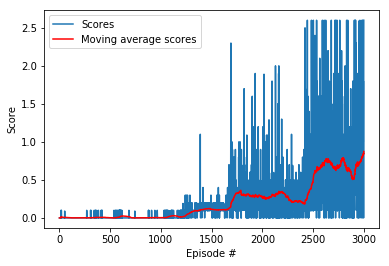

In [11]:
plot_scores(scores)

In [12]:
print('Loading model with best score of ', best_avg_score[0])
best_avg_score = load_checkpoint(agent, filename='checkpoint_best.pth.tar')
best_avg_score = [best_avg_score]

Loading model with best score of  0.8730000130645931
=> loading checkpoint with score 2.600000038743019 and avg 0.8730000130645931


Next we try to reduce the learning rate to further improve the model:

In [13]:
agent.actor_optimizer.param_groups[0]['lr']=agent.actor_optimizer.param_groups[0]['lr']/4
agent.critic_optimizer.param_groups[0]['lr']=agent.critic_optimizer.param_groups[0]['lr']/4

In [14]:
scores = ddpg()

Episode 1	Average Score: 0.88	Score: 0.600	Steps: 230
Episode 2	Average Score: 0.87	Score: 0.600	Steps: 222
Episode 3	Average Score: 0.86	Score: 0.600	Steps: 249
Episode 4	Average Score: 0.88	Score: 2.290	Steps: 868
Episode 5	Average Score: 0.90	Score: 1.600	Steps: 610
Episode 6	Average Score: 0.88	Score: 0.190	Steps: 62
Episode 7	Average Score: 0.86	Score: 0.300	Steps: 108
Episode 8	Average Score: 0.86	Score: 1.000	Steps: 371
Episode 9	Average Score: 0.85	Score: 0.100	Steps: 51
Episode 10	Average Score: 0.87	Score: 2.600	Steps: 0
Episode 11	Average Score: 0.87	Score: 1.600	Steps: 608
Episode 12	Average Score: 0.87	Score: 0.400	Steps: 129
Episode 13	Average Score: 0.85	Score: 0.300	Steps: 107
Episode 14	Average Score: 0.83	Score: 0.690	Steps: 254
Episode 15	Average Score: 0.82	Score: 0.200	Steps: 89
Episode 16	Average Score: 0.82	Score: 1.100	Steps: 402
Episode 17	Average Score: 0.80	Score: 0.090	Steps: 30
Episode 18	Average Score: 0.80	Score: 0.190	Steps: 60
Episode 19	Average Score: 

Episode 151	Average Score: 0.48	Score: 0.100	Steps: 31
Episode 152	Average Score: 0.47	Score: 0.400	Steps: 163
Episode 153	Average Score: 0.48	Score: 1.300	Steps: 508
Episode 154	Average Score: 0.48	Score: 0.300	Steps: 127
Episode 155	Average Score: 0.48	Score: 0.400	Steps: 166
Episode 156	Average Score: 0.50	Score: 1.400	Steps: 583
Episode 157	Average Score: 0.50	Score: 0.200	Steps: 69
Episode 158	Average Score: 0.50	Score: 0.100	Steps: 64
Episode 159	Average Score: 0.50	Score: 0.300	Steps: 110
Episode 160	Average Score: 0.50	Score: 1.400	Steps: 570
Episode 161	Average Score: 0.49	Score: 0.700	Steps: 281
Episode 162	Average Score: 0.49	Score: 0.400	Steps: 164
Episode 163	Average Score: 0.49	Score: 0.100	Steps: 51
Episode 164	Average Score: 0.49	Score: 0.900	Steps: 336
Episode 165	Average Score: 0.47	Score: 0.100	Steps: 63
Episode 166	Average Score: 0.45	Score: 0.200	Steps: 83
Episode 167	Average Score: 0.45	Score: 0.100	Steps: 51
Episode 168	Average Score: 0.44	Score: 1.890	Steps: 733

Episode 299	Average Score: 0.82	Score: 0.500	Steps: 203
Episode 300	Average Score: 0.84	Score: 2.400	Steps: 906
Episode 301	Average Score: 0.86	Score: 2.600	Steps: 0
Episode 302	Average Score: 0.87	Score: 1.200	Steps: 459
Episode 303	Average Score: 0.87	Score: 0.900	Steps: 351
Episode 304	Average Score: 0.88	Score: 1.400	Steps: 537
Episode 305	Average Score: 0.88	Score: 0.200	Steps: 86
Episode 306	Average Score: 0.89	Score: 1.000	Steps: 375
Episode 307	Average Score: 0.90	Score: 1.600	Steps: 601
Episode 308	Average Score: 0.90	Score: 0.100	Steps: 44
Episode 309	Average Score: 0.92	Score: 2.600	Steps: 0
Episode 310	Average Score: 0.93	Score: 1.400	Steps: 535
Episode 311	Average Score: 0.93	Score: 0.100	Steps: 49
Episode 312	Average Score: 0.93	Score: 0.700	Steps: 279
Episode 313	Average Score: 0.95	Score: 1.500	Steps: 583
Episode 314	Average Score: 0.95	Score: 0.790	Steps: 291
Episode 315	Average Score: 0.95	Score: 0.200	Steps: 69
Episode 316	Average Score: 0.95	Score: 0.600	Steps: 220


Episode 448	Average Score: 0.54	Score: 0.600	Steps: 222
Episode 449	Average Score: 0.54	Score: 0.100	Steps: 65
Episode 450	Average Score: 0.55	Score: 0.900	Steps: 337
Episode 451	Average Score: 0.55	Score: 0.300	Steps: 102
Episode 452	Average Score: 0.55	Score: 0.400	Steps: 156
Episode 453	Average Score: 0.55	Score: 0.100	Steps: 30
Episode 454	Average Score: 0.55	Score: 2.200	Steps: 829
Episode 455	Average Score: 0.55	Score: 1.200	Steps: 461
Episode 456	Average Score: 0.56	Score: 1.200	Steps: 445
Episode 457	Average Score: 0.57	Score: 1.000	Steps: 388
Episode 458	Average Score: 0.57	Score: 1.300	Steps: 488
Episode 459	Average Score: 0.57	Score: 0.900	Steps: 352
Episode 460	Average Score: 0.56	Score: 0.200	Steps: 89
Episode 461	Average Score: 0.56	Score: 0.400	Steps: 141
Episode 462	Average Score: 0.56	Score: 0.600	Steps: 241
Episode 463	Average Score: 0.56	Score: 0.400	Steps: 146
Episode 464	Average Score: 0.56	Score: 0.500	Steps: 184
Episode 465	Average Score: 0.56	Score: 0.100	Steps:

Episode 595	Average Score: 0.82	Score: 1.000	Steps: 388
Episode 596	Average Score: 0.80	Score: 0.400	Steps: 165
Episode 597	Average Score: 0.79	Score: 0.600	Steps: 240
Episode 598	Average Score: 0.82	Score: 2.600	Steps: 981
Episode 599	Average Score: 0.81	Score: 0.700	Steps: 259
Episode 600	Average Score: 0.83	Score: 1.600	Steps: 601
Episode 601	Average Score: 0.84	Score: 2.300	Steps: 878
Episode 602	Average Score: 0.84	Score: 1.200	Steps: 449
Episode 603	Average Score: 0.85	Score: 2.600	Steps: 0
Episode 604	Average Score: 0.85	Score: 0.500	Steps: 191
Episode 605	Average Score: 0.83	Score: 0.100	Steps: 51
Episode 606	Average Score: 0.84	Score: 1.590	Steps: 610
Episode 607	Average Score: 0.84	Score: 2.000	Steps: 775
Episode 608	Average Score: 0.86	Score: 1.100	Steps: 438
Episode 609	Average Score: 0.85	Score: 0.100	Steps: 63
Episode 610	Average Score: 0.86	Score: 1.600	Steps: 601
Episode 611	Average Score: 0.85	Score: 0.000	Steps: 13
Episode 612	Average Score: 0.86	Score: 1.300	Steps: 5

Episode 743	Average Score: 0.74	Score: 0.100	Steps: 51
Episode 744	Average Score: 0.77	Score: 2.600	Steps: 0
Episode 745	Average Score: 0.78	Score: 1.100	Steps: 426
Episode 746	Average Score: 0.77	Score: 0.500	Steps: 192
Episode 747	Average Score: 0.76	Score: 0.200	Steps: 89
Episode 748	Average Score: 0.77	Score: 1.400	Steps: 545
Episode 749	Average Score: 0.79	Score: 2.100	Steps: 812
Episode 750	Average Score: 0.78	Score: 0.300	Steps: 105
Episode 751	Average Score: 0.80	Score: 2.600	Steps: 0
Episode 752	Average Score: 0.80	Score: 0.100	Steps: 40
Episode 753	Average Score: 0.80	Score: 1.300	Steps: 489
Episode 754	Average Score: 0.82	Score: 2.600	Steps: 0
Episode 755	Average Score: 0.81	Score: 0.000	Steps: 3
Episode 756	Average Score: 0.81	Score: 0.590	Steps: 212
Episode 757	Average Score: 0.80	Score: 0.290	Steps: 108
Episode 758	Average Score: 0.81	Score: 0.400	Steps: 149
Episode 759	Average Score: 0.83	Score: 2.600	Steps: 0
Episode 760	Average Score: 0.83	Score: 0.000	Steps: 3
Episode

Episode 891	Average Score: 0.80	Score: 0.500	Steps: 203
Episode 892	Average Score: 0.78	Score: 0.800	Steps: 300
Episode 893	Average Score: 0.78	Score: 0.200	Steps: 89
Episode 894	Average Score: 0.78	Score: 0.600	Steps: 241
Episode 895	Average Score: 0.76	Score: 0.200	Steps: 89
Episode 896	Average Score: 0.76	Score: 0.600	Steps: 223
Episode 897	Average Score: 0.75	Score: 0.700	Steps: 260
Episode 898	Average Score: 0.75	Score: 2.100	Steps: 809
Episode 899	Average Score: 0.75	Score: 0.500	Steps: 183
Episode 900	Average Score: 0.75	Score: 0.700	Steps: 260
Episode 901	Average Score: 0.74	Score: 0.400	Steps: 144
Episode 902	Average Score: 0.75	Score: 0.400	Steps: 165
Episode 903	Average Score: 0.74	Score: 0.100	Steps: 51
Episode 904	Average Score: 0.74	Score: 0.800	Steps: 298
Episode 905	Average Score: 0.73	Score: 1.300	Steps: 507
Episode 906	Average Score: 0.71	Score: 0.600	Steps: 240
Episode 907	Average Score: 0.72	Score: 1.800	Steps: 698
Episode 908	Average Score: 0.71	Score: 0.000	Steps:

Episode 1038	Average Score: 0.71	Score: 0.100	Steps: 29
Episode 1039	Average Score: 0.73	Score: 1.600	Steps: 602
Episode 1040	Average Score: 0.73	Score: 0.290	Steps: 98
Episode 1041	Average Score: 0.74	Score: 0.900	Steps: 355
Episode 1042	Average Score: 0.73	Score: 0.100	Steps: 45
Episode 1043	Average Score: 0.73	Score: 0.100	Steps: 29
Episode 1044	Average Score: 0.74	Score: 1.200	Steps: 468
Episode 1045	Average Score: 0.74	Score: 0.400	Steps: 162
Episode 1046	Average Score: 0.73	Score: 0.800	Steps: 318
Episode 1047	Average Score: 0.73	Score: 0.300	Steps: 121
Episode 1048	Average Score: 0.73	Score: 2.100	Steps: 804
Episode 1049	Average Score: 0.73	Score: 0.500	Steps: 184
Episode 1050	Average Score: 0.73	Score: 0.700	Steps: 280
Episode 1051	Average Score: 0.73	Score: 0.800	Steps: 325
Episode 1052	Average Score: 0.75	Score: 2.600	Steps: 0
Episode 1053	Average Score: 0.75	Score: 0.100	Steps: 21
Episode 1054	Average Score: 0.77	Score: 1.700	Steps: 634
Episode 1055	Average Score: 0.77	Score

Episode 1183	Average Score: 0.74	Score: 0.400	Steps: 147
Episode 1184	Average Score: 0.74	Score: 0.000	Steps: 13
Episode 1185	Average Score: 0.73	Score: 0.000	Steps: 13
Episode 1186	Average Score: 0.73	Score: 1.600	Steps: 603
Episode 1187	Average Score: 0.71	Score: 0.200	Steps: 89
Episode 1188	Average Score: 0.71	Score: 0.000	Steps: 13
Episode 1189	Average Score: 0.70	Score: 0.300	Steps: 115
Episode 1190	Average Score: 0.69	Score: 0.100	Steps: 51
Episode 1191	Average Score: 0.70	Score: 0.600	Steps: 257
Episode 1192	Average Score: 0.69	Score: 0.100	Steps: 44
Episode 1193	Average Score: 0.69	Score: 1.200	Steps: 470
Episode 1194	Average Score: 0.68	Score: 1.100	Steps: 432
Episode 1195	Average Score: 0.68	Score: 0.300	Steps: 127
Episode 1196	Average Score: 0.68	Score: 0.100	Steps: 48
Episode 1197	Average Score: 0.66	Score: 0.600	Steps: 241
Episode 1198	Average Score: 0.67	Score: 0.800	Steps: 299
Episode 1199	Average Score: 0.69	Score: 2.600	Steps: 0
Episode 1200	Average Score: 0.67	Score: 

Episode 1328	Average Score: 0.77	Score: 1.800	Steps: 694
Episode 1329	Average Score: 0.77	Score: 0.200	Steps: 89
Episode 1330	Average Score: 0.78	Score: 2.100	Steps: 806
Episode 1331	Average Score: 0.79	Score: 2.400	Steps: 902
Episode 1332	Average Score: 0.78	Score: 0.200	Steps: 64
Episode 1333	Average Score: 0.77	Score: 0.100	Steps: 28
Episode 1334	Average Score: 0.78	Score: 1.700	Steps: 656
Episode 1335	Average Score: 0.79	Score: 2.090	Steps: 787
Episode 1336	Average Score: 0.80	Score: 0.400	Steps: 146
Episode 1337	Average Score: 0.80	Score: 1.500	Steps: 582
Episode 1338	Average Score: 0.80	Score: 0.100	Steps: 50
Episode 1339	Average Score: 0.80	Score: 0.200	Steps: 65
Episode 1340	Average Score: 0.81	Score: 1.200	Steps: 447
Episode 1341	Average Score: 0.80	Score: 1.000	Steps: 372
Episode 1342	Average Score: 0.80	Score: 0.800	Steps: 314
Episode 1343	Average Score: 0.81	Score: 1.800	Steps: 692
Episode 1344	Average Score: 0.82	Score: 1.400	Steps: 540
Episode 1345	Average Score: 0.82	Sco

Episode 1473	Average Score: 0.80	Score: 0.900	Steps: 336
Episode 1474	Average Score: 0.81	Score: 1.000	Steps: 426
Episode 1475	Average Score: 0.80	Score: 0.400	Steps: 165
Episode 1476	Average Score: 0.79	Score: 0.800	Steps: 321
Episode 1477	Average Score: 0.79	Score: 0.100	Steps: 51
Episode 1478	Average Score: 0.78	Score: 0.800	Steps: 318
Episode 1479	Average Score: 0.78	Score: 0.900	Steps: 351
Episode 1480	Average Score: 0.78	Score: 0.500	Steps: 185
Episode 1481	Average Score: 0.78	Score: 0.100	Steps: 51
Episode 1482	Average Score: 0.77	Score: 0.400	Steps: 147
Episode 1483	Average Score: 0.77	Score: 0.400	Steps: 165
Episode 1484	Average Score: 0.75	Score: 0.300	Steps: 108
Episode 1485	Average Score: 0.75	Score: 0.500	Steps: 200
Episode 1486	Average Score: 0.74	Score: 0.100	Steps: 41
Episode 1487	Average Score: 0.73	Score: 0.200	Steps: 70
Episode 1488	Average Score: 0.72	Score: 0.500	Steps: 181
Episode 1489	Average Score: 0.72	Score: 0.300	Steps: 102
Episode 1490	Average Score: 0.72	Sc

Episode 1618	Average Score: 0.95	Score: 0.100	Steps: 29
Episode 1619	Average Score: 0.95	Score: 1.100	Steps: 426
Episode 1620	Average Score: 0.96	Score: 0.300	Steps: 127
Episode 1621	Average Score: 0.95	Score: 0.100	Steps: 50
Episode 1622	Average Score: 0.97	Score: 1.700	Steps: 646
Episode 1623	Average Score: 0.98	Score: 1.800	Steps: 699
Episode 1624	Average Score: 0.97	Score: 0.000	Steps: 13
Episode 1625	Average Score: 0.96	Score: 0.390	Steps: 144
Episode 1626	Average Score: 0.97	Score: 1.000	Steps: 388
Episode 1627	Average Score: 0.96	Score: 0.200	Steps: 89
Episode 1628	Average Score: 0.96	Score: 0.100	Steps: 23
Episode 1629	Average Score: 0.96	Score: 1.500	Steps: 583
Episode 1630	Average Score: 0.94	Score: 0.600	Steps: 238
Episode 1631	Average Score: 0.95	Score: 0.900	Steps: 353
Episode 1632	Average Score: 0.95	Score: 0.600	Steps: 222
Episode 1633	Average Score: 0.97	Score: 2.400	Steps: 923
Episode 1634	Average Score: 0.97	Score: 0.390	Steps: 143
Episode 1635	Average Score: 0.95	Sco

Episode 1763	Average Score: 0.84	Score: 0.700	Steps: 274
Episode 1764	Average Score: 0.84	Score: 0.000	Steps: 13
Episode 1765	Average Score: 0.82	Score: 0.700	Steps: 261
Episode 1766	Average Score: 0.83	Score: 1.300	Steps: 507
Episode 1767	Average Score: 0.83	Score: 1.500	Steps: 566
Episode 1768	Average Score: 0.83	Score: 2.000	Steps: 757
Episode 1769	Average Score: 0.85	Score: 2.600	Steps: 0
Episode 1770	Average Score: 0.85	Score: 0.100	Steps: 35
Episode 1771	Average Score: 0.84	Score: 0.900	Steps: 335
Episode 1772	Average Score: 0.84	Score: 0.100	Steps: 51
Episode 1773	Average Score: 0.84	Score: 0.200	Steps: 82
Episode 1774	Average Score: 0.85	Score: 2.400	Steps: 924
Episode 1775	Average Score: 0.84	Score: 0.400	Steps: 166
Episode 1776	Average Score: 0.83	Score: 1.200	Steps: 464
Episode 1777	Average Score: 0.83	Score: 0.400	Steps: 164
Episode 1778	Average Score: 0.83	Score: 0.500	Steps: 202
Episode 1779	Average Score: 0.81	Score: 0.900	Steps: 349
Episode 1780	Average Score: 0.82	Scor

Episode 1908	Average Score: 0.79	Score: 0.600	Steps: 215
Episode 1909	Average Score: 0.79	Score: 2.200	Steps: 848
Episode 1910	Average Score: 0.80	Score: 0.300	Steps: 127
Episode 1911	Average Score: 0.79	Score: 0.200	Steps: 80
Episode 1912	Average Score: 0.78	Score: 0.500	Steps: 184
Episode 1913	Average Score: 0.78	Score: 1.100	Steps: 430
Episode 1914	Average Score: 0.77	Score: 0.100	Steps: 51
Episode 1915	Average Score: 0.76	Score: 0.000	Steps: 13
Episode 1916	Average Score: 0.77	Score: 1.900	Steps: 731
Episode 1917	Average Score: 0.76	Score: 0.600	Steps: 241
Episode 1918	Average Score: 0.74	Score: 0.100	Steps: 50
Episode 1919	Average Score: 0.76	Score: 2.100	Steps: 817
Episode 1920	Average Score: 0.76	Score: 0.100	Steps: 51
Episode 1921	Average Score: 0.76	Score: 0.400	Steps: 165
Episode 1922	Average Score: 0.76	Score: 1.000	Steps: 395
Episode 1923	Average Score: 0.74	Score: 0.700	Steps: 279
Episode 1924	Average Score: 0.75	Score: 0.900	Steps: 350
Episode 1925	Average Score: 0.75	Sco

Episode 2053	Average Score: 0.79	Score: 0.390	Steps: 139
Episode 2054	Average Score: 0.78	Score: 0.190	Steps: 62
Episode 2055	Average Score: 0.78	Score: 0.890	Steps: 327
Episode 2056	Average Score: 0.79	Score: 1.500	Steps: 583
Episode 2057	Average Score: 0.80	Score: 2.600	Steps: 0
Episode 2058	Average Score: 0.82	Score: 2.300	Steps: 853
Episode 2059	Average Score: 0.82	Score: 0.700	Steps: 296
Episode 2060	Average Score: 0.83	Score: 0.700	Steps: 260
Episode 2061	Average Score: 0.81	Score: 0.000	Steps: 13
Episode 2062	Average Score: 0.80	Score: 0.600	Steps: 235
Episode 2063	Average Score: 0.82	Score: 2.600	Steps: 0
Episode 2064	Average Score: 0.83	Score: 0.990	Steps: 353
Episode 2065	Average Score: 0.83	Score: 0.500	Steps: 162
Episode 2066	Average Score: 0.86	Score: 2.600	Steps: 0
Episode 2067	Average Score: 0.86	Score: 0.500	Steps: 194
Episode 2068	Average Score: 0.86	Score: 0.600	Steps: 221
Episode 2069	Average Score: 0.85	Score: 0.400	Steps: 165
Episode 2070	Average Score: 0.85	Score:

Episode 2198	Average Score: 0.79	Score: 1.200	Steps: 469
Episode 2199	Average Score: 0.77	Score: 0.300	Steps: 102
Episode 2200	Average Score: 0.79	Score: 2.600	Steps: 0
Episode 2201	Average Score: 0.79	Score: 0.100	Steps: 37
Episode 2202	Average Score: 0.80	Score: 1.200	Steps: 440
Episode 2203	Average Score: 0.80	Score: 2.200	Steps: 839
Episode 2204	Average Score: 0.82	Score: 1.700	Steps: 657
Episode 2205	Average Score: 0.82	Score: 1.800	Steps: 690
Episode 2206	Average Score: 0.82	Score: 0.200	Steps: 80
Episode 2207	Average Score: 0.81	Score: 0.300	Steps: 108
Episode 2208	Average Score: 0.82	Score: 0.400	Steps: 145
Episode 2209	Average Score: 0.82	Score: 0.500	Steps: 186
Episode 2210	Average Score: 0.81	Score: 0.400	Steps: 168
Episode 2211	Average Score: 0.83	Score: 2.600	Steps: 0
Episode 2212	Average Score: 0.82	Score: 1.700	Steps: 617
Episode 2213	Average Score: 0.81	Score: 1.800	Steps: 676
Episode 2214	Average Score: 0.82	Score: 0.390	Steps: 154
Episode 2215	Average Score: 0.83	Scor

Episode 2343	Average Score: 0.74	Score: 0.600	Steps: 242
Episode 2344	Average Score: 0.73	Score: 0.000	Steps: 13
Episode 2345	Average Score: 0.73	Score: 0.800	Steps: 312
Episode 2346	Average Score: 0.73	Score: 0.100	Steps: 51
Episode 2347	Average Score: 0.73	Score: 0.400	Steps: 164
Episode 2348	Average Score: 0.73	Score: 1.200	Steps: 469
Episode 2349	Average Score: 0.72	Score: 0.200	Steps: 76
Episode 2350	Average Score: 0.72	Score: 0.600	Steps: 237
Episode 2351	Average Score: 0.71	Score: 0.300	Steps: 126
Episode 2352	Average Score: 0.72	Score: 0.500	Steps: 184
Episode 2353	Average Score: 0.72	Score: 0.590	Steps: 207
Episode 2354	Average Score: 0.72	Score: 0.100	Steps: 32
Episode 2355	Average Score: 0.72	Score: 0.100	Steps: 50
Episode 2356	Average Score: 0.71	Score: 0.000	Steps: 13
Episode 2357	Average Score: 0.72	Score: 0.800	Steps: 294
Episode 2358	Average Score: 0.72	Score: 0.300	Steps: 126
Episode 2359	Average Score: 0.73	Score: 0.900	Steps: 338
Episode 2360	Average Score: 0.73	Scor

Episode 2488	Average Score: 0.76	Score: 0.100	Steps: 29
Episode 2489	Average Score: 0.75	Score: 0.100	Steps: 29
Episode 2490	Average Score: 0.74	Score: 0.890	Steps: 335
Episode 2491	Average Score: 0.73	Score: 0.500	Steps: 178
Episode 2492	Average Score: 0.74	Score: 0.300	Steps: 138
Episode 2493	Average Score: 0.75	Score: 1.400	Steps: 544
Episode 2494	Average Score: 0.76	Score: 2.600	Steps: 0
Episode 2495	Average Score: 0.77	Score: 1.200	Steps: 437
Episode 2496	Average Score: 0.79	Score: 2.200	Steps: 865
Episode 2497	Average Score: 0.78	Score: 0.200	Steps: 52
Episode 2498	Average Score: 0.76	Score: 0.600	Steps: 239
Episode 2499	Average Score: 0.76	Score: 0.300	Steps: 126
Episode 2500	Average Score: 0.76	Score: 1.000	Steps: 374
Episode 2500	Average Score: 0.76
Episode 2501	Average Score: 0.74	Score: 0.300	Steps: 110
Episode 2502	Average Score: 0.74	Score: 0.390	Steps: 160
Episode 2503	Average Score: 0.74	Score: 0.300	Steps: 110
Episode 2504	Average Score: 0.74	Score: 0.100	Steps: 57
Epis

Episode 2633	Average Score: 0.75	Score: 1.000	Steps: 367
Episode 2634	Average Score: 0.75	Score: 0.200	Steps: 87
Episode 2635	Average Score: 0.75	Score: 0.790	Steps: 294
Episode 2636	Average Score: 0.73	Score: 0.100	Steps: 29
Episode 2637	Average Score: 0.72	Score: 0.500	Steps: 202
Episode 2638	Average Score: 0.73	Score: 0.300	Steps: 127
Episode 2639	Average Score: 0.73	Score: 0.500	Steps: 184
Episode 2640	Average Score: 0.72	Score: 0.100	Steps: 51
Episode 2641	Average Score: 0.73	Score: 0.700	Steps: 259
Episode 2642	Average Score: 0.73	Score: 2.600	Steps: 0
Episode 2643	Average Score: 0.72	Score: 0.000	Steps: 1
Episode 2644	Average Score: 0.72	Score: 0.690	Steps: 259
Episode 2645	Average Score: 0.74	Score: 2.400	Steps: 926
Episode 2646	Average Score: 0.75	Score: 1.800	Steps: 697
Episode 2647	Average Score: 0.76	Score: 2.500	Steps: 958
Episode 2648	Average Score: 0.75	Score: 0.100	Steps: 51
Episode 2649	Average Score: 0.76	Score: 2.000	Steps: 754
Episode 2650	Average Score: 0.77	Score:

Episode 2778	Average Score: 0.79	Score: 0.200	Steps: 81
Episode 2779	Average Score: 0.79	Score: 0.300	Steps: 110
Episode 2780	Average Score: 0.78	Score: 0.200	Steps: 69
Episode 2781	Average Score: 0.77	Score: 0.300	Steps: 118
Episode 2782	Average Score: 0.77	Score: 0.590	Steps: 213
Episode 2783	Average Score: 0.77	Score: 0.300	Steps: 126
Episode 2784	Average Score: 0.76	Score: 0.300	Steps: 137
Episode 2785	Average Score: 0.75	Score: 0.200	Steps: 70
Episode 2786	Average Score: 0.74	Score: 0.200	Steps: 105
Episode 2787	Average Score: 0.74	Score: 0.100	Steps: 31
Episode 2788	Average Score: 0.75	Score: 0.700	Steps: 272
Episode 2789	Average Score: 0.72	Score: 0.200	Steps: 113
Episode 2790	Average Score: 0.73	Score: 2.000	Steps: 767
Episode 2791	Average Score: 0.73	Score: 0.900	Steps: 328
Episode 2792	Average Score: 0.73	Score: 0.800	Steps: 315
Episode 2793	Average Score: 0.74	Score: 0.400	Steps: 164
Episode 2794	Average Score: 0.74	Score: 1.100	Steps: 430
Episode 2795	Average Score: 0.76	Sc

Episode 2923	Average Score: 0.82	Score: 1.200	Steps: 450
Episode 2924	Average Score: 0.82	Score: 0.100	Steps: 51
Episode 2925	Average Score: 0.81	Score: 0.000	Steps: 13
Episode 2926	Average Score: 0.82	Score: 0.900	Steps: 336
Episode 2927	Average Score: 0.79	Score: 0.090	Steps: 18
Episode 2928	Average Score: 0.80	Score: 0.300	Steps: 108
Episode 2929	Average Score: 0.81	Score: 1.800	Steps: 685
Episode 2930	Average Score: 0.82	Score: 1.600	Steps: 597
Episode 2931	Average Score: 0.83	Score: 0.590	Steps: 210
Episode 2932	Average Score: 0.84	Score: 2.600	Steps: 0
Episode 2933	Average Score: 0.84	Score: 0.190	Steps: 49
Episode 2934	Average Score: 0.85	Score: 1.300	Steps: 483
Episode 2935	Average Score: 0.83	Score: 1.000	Steps: 388
Episode 2936	Average Score: 0.82	Score: 0.800	Steps: 298
Episode 2937	Average Score: 0.82	Score: 0.090	Steps: 49
Episode 2938	Average Score: 0.82	Score: 0.400	Steps: 146
Episode 2939	Average Score: 0.82	Score: 2.600	Steps: 0
Episode 2940	Average Score: 0.82	Score: 

Max mooving average Score:  1.1380000170320272 at Episode #: 4


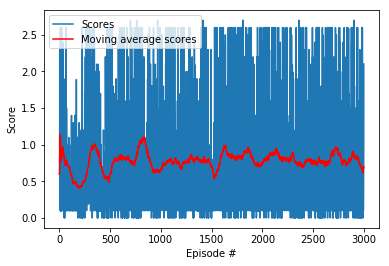

In [15]:
plot_scores(scores)

We see that the model is not improving any more with the current parameters.

### 4. Evaluate score over 100 games

To execute the code as fast as possible: 

    env.reset(train_mode=True) 

To remove the random exploration part of the action:

    actions = agent.act(states, add_noise=False)

In [6]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment   

num_agents = len(env_info.agents)
action_size = brain.vector_action_space_size
states = env_info.vector_observations
state_size = states.shape[1]

In [7]:
# Load the Agent and load the best parameters
agent = Agents(state_size=state_size, action_size=action_size,
               num_agents = num_agents, random_seed=0)
load_checkpoint(agent, filename='checkpoint_best.pth.tar')

=> loading checkpoint with score 2.2000000327825546 and avg 1.0966000163555145 from episode 834


In [18]:
def test_ddpg(n_episodes=100):
    scores = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        agent.reset()
        score = np.zeros(num_agents)
        while True:
            actions = agent.act(states, add_noise=False)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            states = next_states
            score += rewards
            if np.any(dones):
                break 
        scores.append(np.max(score))
        print('\r{}: {:.3f}'.format(i_episode, np.max(score)), end='')
    return scores

Mean score over 100 episodes: 1.0429000156372785


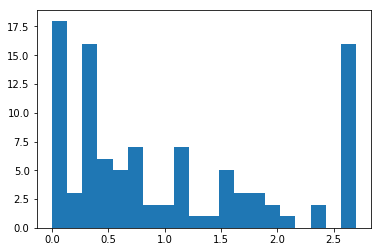

In [36]:
n_episodes = 100
scores = test_ddpg(n_episodes)
print('\rMean score over {} episodes: {}'.format(n_episodes, np.mean(scores)))
h = plt.hist(np.array(scores), 20)

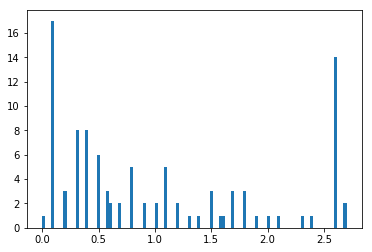

In [37]:
h = plt.hist(np.array(scores), 100)

*From the histogram above we can observe that there are a lot of games with scores close to zero. This means that the model needs special training for the initial phase of the game.*

### 5. More training for the initial phase of the game

To limit the training only to the initial part of the game we reduce the number of steps from **1000** to **100**, i.e. `max_t=100`:

    scores = ddpg(1000, max_t=100)

To reduce the chance to mess up with the already quite good model we:

- reduce the noise that is added to the action and 
- increase the batch size

In [31]:
print('Loading model with best score of ', best_avg_score[0])
load_checkpoint(agent, filename='checkpoint_best.pth.tar')

Loading model with best score of  1.0966000163555145
=> loading checkpoint with score 2.2000000327825546 and avg 1.0966000163555145


1.0966000163555145

In [9]:
agent.memory.batch_size = agent.memory.batch_size * 4

In [10]:
agent.noise.sigma = agent.noise.sigma/4

In [15]:
best_avg_score = [1.5] # too high so we keep our best model
scores = ddpg(1000, max_t=100)

Episode 1	Average Score: 0.19	Score: 0.000	Steps: 7
Episode 2	Average Score: 0.20	Score: 0.300	Steps: 0
Episode 3	Average Score: 0.19	Score: 0.000	Steps: 7
Episode 4	Average Score: 0.19	Score: 0.200	Steps: 84
Episode 5	Average Score: 0.20	Score: 0.300	Steps: 0
Episode 6	Average Score: 0.19	Score: 0.000	Steps: 7
Episode 7	Average Score: 0.19	Score: 0.300	Steps: 0
Episode 8	Average Score: 0.20	Score: 0.300	Steps: 0
Episode 9	Average Score: 0.19	Score: 0.000	Steps: 3
Episode 10	Average Score: 0.19	Score: 0.300	Steps: 0
Episode 11	Average Score: 0.20	Score: 0.300	Steps: 0
Episode 12	Average Score: 0.20	Score: 0.300	Steps: 0
Episode 13	Average Score: 0.20	Score: 0.300	Steps: 0
Episode 14	Average Score: 0.20	Score: 0.300	Steps: 0
Episode 15	Average Score: 0.20	Score: 0.300	Steps: 0
Episode 16	Average Score: 0.20	Score: 0.300	Steps: 0
Episode 17	Average Score: 0.20	Score: 0.300	Steps: 0
Episode 18	Average Score: 0.20	Score: 0.300	Steps: 0
Episode 19	Average Score: 0.21	Score: 0.300	Steps: 0
E

Episode 155	Average Score: 0.26	Score: 0.300	Steps: 0
Episode 156	Average Score: 0.26	Score: 0.300	Steps: 0
Episode 157	Average Score: 0.26	Score: 0.300	Steps: 0
Episode 158	Average Score: 0.26	Score: 0.300	Steps: 0
Episode 159	Average Score: 0.26	Score: 0.300	Steps: 0
Episode 160	Average Score: 0.26	Score: 0.300	Steps: 0
Episode 161	Average Score: 0.26	Score: 0.300	Steps: 0
Episode 162	Average Score: 0.26	Score: 0.300	Steps: 0
Episode 163	Average Score: 0.26	Score: 0.300	Steps: 0
Episode 164	Average Score: 0.26	Score: 0.300	Steps: 0
Episode 165	Average Score: 0.26	Score: 0.300	Steps: 0
Episode 166	Average Score: 0.26	Score: 0.300	Steps: 0
Episode 167	Average Score: 0.26	Score: 0.300	Steps: 0
Episode 168	Average Score: 0.26	Score: 0.000	Steps: 4
Episode 169	Average Score: 0.26	Score: 0.100	Steps: 50
Episode 170	Average Score: 0.26	Score: 0.300	Steps: 0
Episode 171	Average Score: 0.26	Score: 0.300	Steps: 0
Episode 172	Average Score: 0.26	Score: 0.300	Steps: 0
Episode 173	Average Score: 

Episode 308	Average Score: 0.24	Score: 0.300	Steps: 0
Episode 309	Average Score: 0.24	Score: 0.300	Steps: 0
Episode 310	Average Score: 0.24	Score: 0.000	Steps: 3
Episode 311	Average Score: 0.24	Score: 0.300	Steps: 0
Episode 312	Average Score: 0.24	Score: 0.300	Steps: 0
Episode 313	Average Score: 0.23	Score: 0.000	Steps: 3
Episode 314	Average Score: 0.23	Score: 0.090	Steps: 30
Episode 315	Average Score: 0.24	Score: 0.300	Steps: 0
Episode 316	Average Score: 0.24	Score: 0.300	Steps: 0
Episode 317	Average Score: 0.23	Score: 0.000	Steps: 3
Episode 318	Average Score: 0.23	Score: 0.100	Steps: 51
Episode 319	Average Score: 0.23	Score: 0.100	Steps: 51
Episode 320	Average Score: 0.23	Score: 0.300	Steps: 0
Episode 321	Average Score: 0.23	Score: 0.300	Steps: 0
Episode 322	Average Score: 0.23	Score: 0.000	Steps: 3
Episode 323	Average Score: 0.22	Score: 0.100	Steps: 51
Episode 324	Average Score: 0.22	Score: 0.300	Steps: 0
Episode 325	Average Score: 0.22	Score: 0.300	Steps: 0
Episode 326	Average Scor

Episode 460	Average Score: 0.28	Score: 0.300	Steps: 0
Episode 461	Average Score: 0.28	Score: 0.300	Steps: 0
Episode 462	Average Score: 0.28	Score: 0.300	Steps: 0
Episode 463	Average Score: 0.28	Score: 0.300	Steps: 0
Episode 464	Average Score: 0.28	Score: 0.300	Steps: 0
Episode 465	Average Score: 0.28	Score: 0.300	Steps: 0
Episode 466	Average Score: 0.28	Score: 0.300	Steps: 0
Episode 467	Average Score: 0.28	Score: 0.000	Steps: 5
Episode 468	Average Score: 0.28	Score: 0.300	Steps: 0
Episode 469	Average Score: 0.28	Score: 0.300	Steps: 0
Episode 470	Average Score: 0.28	Score: 0.300	Steps: 0
Episode 471	Average Score: 0.28	Score: 0.300	Steps: 0
Episode 472	Average Score: 0.28	Score: 0.300	Steps: 0
Episode 473	Average Score: 0.28	Score: 0.100	Steps: 15
Episode 474	Average Score: 0.28	Score: 0.300	Steps: 0
Episode 475	Average Score: 0.28	Score: 0.300	Steps: 0
Episode 476	Average Score: 0.28	Score: 0.000	Steps: 3
Episode 477	Average Score: 0.28	Score: 0.300	Steps: 0
Episode 478	Average Score: 

Episode 611	Average Score: 0.27	Score: 0.300	Steps: 0
Episode 612	Average Score: 0.27	Score: 0.300	Steps: 0
Episode 613	Average Score: 0.27	Score: 0.300	Steps: 0
Episode 614	Average Score: 0.27	Score: 0.300	Steps: 0
Episode 615	Average Score: 0.27	Score: 0.300	Steps: 0
Episode 616	Average Score: 0.27	Score: 0.200	Steps: 62
Episode 617	Average Score: 0.27	Score: 0.300	Steps: 0
Episode 618	Average Score: 0.27	Score: 0.300	Steps: 0
Episode 619	Average Score: 0.27	Score: 0.300	Steps: 0
Episode 620	Average Score: 0.27	Score: 0.200	Steps: 52
Episode 621	Average Score: 0.27	Score: 0.300	Steps: 0
Episode 622	Average Score: 0.27	Score: 0.300	Steps: 0
Episode 623	Average Score: 0.27	Score: 0.300	Steps: 0
Episode 624	Average Score: 0.27	Score: 0.300	Steps: 0
Episode 625	Average Score: 0.27	Score: 0.300	Steps: 0
Episode 626	Average Score: 0.27	Score: 0.000	Steps: 4
Episode 627	Average Score: 0.27	Score: 0.300	Steps: 0
Episode 628	Average Score: 0.27	Score: 0.300	Steps: 0
Episode 629	Average Score:

Episode 763	Average Score: 0.24	Score: 0.300	Steps: 0
Episode 764	Average Score: 0.24	Score: 0.300	Steps: 0
Episode 765	Average Score: 0.24	Score: 0.300	Steps: 0
Episode 766	Average Score: 0.24	Score: 0.100	Steps: 19
Episode 767	Average Score: 0.24	Score: 0.300	Steps: 0
Episode 768	Average Score: 0.24	Score: 0.300	Steps: 0
Episode 769	Average Score: 0.24	Score: 0.300	Steps: 0
Episode 770	Average Score: 0.25	Score: 0.300	Steps: 0
Episode 771	Average Score: 0.25	Score: 0.300	Steps: 0
Episode 772	Average Score: 0.25	Score: 0.300	Steps: 0
Episode 773	Average Score: 0.25	Score: 0.300	Steps: 0
Episode 774	Average Score: 0.25	Score: 0.200	Steps: 73
Episode 775	Average Score: 0.25	Score: 0.300	Steps: 0
Episode 776	Average Score: 0.25	Score: 0.300	Steps: 0
Episode 777	Average Score: 0.25	Score: 0.300	Steps: 0
Episode 778	Average Score: 0.25	Score: 0.300	Steps: 0
Episode 779	Average Score: 0.25	Score: 0.300	Steps: 0
Episode 780	Average Score: 0.25	Score: 0.300	Steps: 0
Episode 781	Average Score:

Episode 915	Average Score: 0.27	Score: 0.300	Steps: 0
Episode 916	Average Score: 0.27	Score: 0.300	Steps: 0
Episode 917	Average Score: 0.27	Score: 0.300	Steps: 0
Episode 918	Average Score: 0.27	Score: 0.300	Steps: 0
Episode 919	Average Score: 0.27	Score: 0.300	Steps: 0
Episode 920	Average Score: 0.27	Score: 0.300	Steps: 0
Episode 921	Average Score: 0.27	Score: 0.300	Steps: 0
Episode 922	Average Score: 0.27	Score: 0.300	Steps: 0
Episode 923	Average Score: 0.27	Score: 0.300	Steps: 0
Episode 924	Average Score: 0.27	Score: 0.300	Steps: 0
Episode 925	Average Score: 0.27	Score: 0.200	Steps: 51
Episode 926	Average Score: 0.27	Score: 0.300	Steps: 0
Episode 927	Average Score: 0.27	Score: 0.300	Steps: 0
Episode 928	Average Score: 0.27	Score: 0.300	Steps: 0
Episode 929	Average Score: 0.27	Score: 0.300	Steps: 0
Episode 930	Average Score: 0.27	Score: 0.300	Steps: 0
Episode 931	Average Score: 0.27	Score: 0.300	Steps: 0
Episode 932	Average Score: 0.27	Score: 0.300	Steps: 0
Episode 933	Average Score: 

Max mooving average Score:  0.28200000420212745 at Episode #: 463


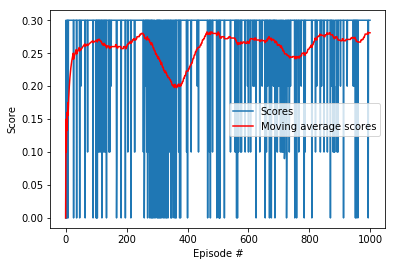

In [16]:
plot_scores(scores)

### 6. Evaluate score over 100 games again

Mean score over 100 episodes: 2.5400000378489493


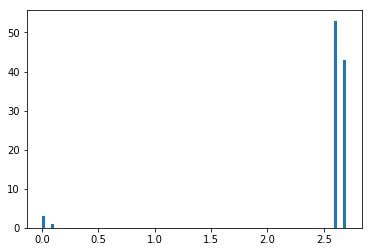

In [19]:
n_episodes = 100
scores = test_ddpg(n_episodes)
print('\rMean score over {} episodes: {}'.format(n_episodes, np.mean(scores)))
h = plt.hist(np.array(scores), 100)

Mean score over 100 episodes: 2.431000036224723


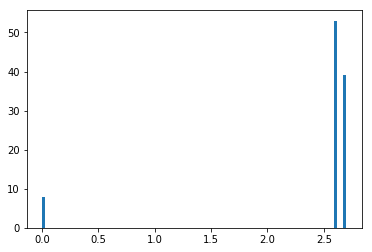

In [20]:
n_episodes = 100
scores = test_ddpg(n_episodes)
print('\rMean score over {} episodes: {}'.format(n_episodes, np.mean(scores)))
h = plt.hist(np.array(scores), 100)

Now we are happy with the result :)

In [21]:
# Save some ot the model paramaters in the required format:
torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')

### 7. Demo play

To slow down the execution to real time: 

    env.reset(train_mode=False) 

To remove the random exploration part of the action:

    actions = agent.act(states, add_noise=False)

In [22]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment   

num_agents = len(env_info.agents)
action_size = brain.vector_action_space_size
states = env_info.vector_observations
state_size = states.shape[1]

In [23]:
agent = Agents(state_size=state_size, action_size=action_size,
               num_agents = num_agents, random_seed=0)
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

In [24]:
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
agent.reset() 
while True:
    actions = agent.act(states, add_noise=False)       # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (max over agents) this episode: {}'.format(np.max(scores)))

Total score (max over agents) this episode: 2.600000038743019


In [25]:
env.close()